In [2]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import csv
import glob
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import pickle
from sklearn import metrics
import noisereduce as nr
import matplotlib.pyplot as plt
from tqdm import tqdm
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from scipy.stats import skew, kurtosis
from librosa import display
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
import pandas as pd
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RandomForest
from tabulate import tabulate
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

AUTOTUNE = tf.data.AUTOTUNE
AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
PREPROCESSED_EXTRACTED_FEATURES_FILE = 'preprocessed_extracted_features_iemocap.csv'
PREPROCESSED_ALL_EXTRACTED_FEATURES_FILE = 'all_preprocessed_extracted_features_iemocap.csv'
EXTRACTED_FEATURES_FILE = 'extracted_features_iemocap.csv'
ALL_EXTRACTED_FEATURES_FILE = 'all_extracted_features_iemocap.csv'
RAW_AUDIO_FILES = 'raw_audio_files.csv'
AUDIO_SPECTROGRAMS_DIR = './../data/spectrograms/'
AUDIO_MFCCS_DIR = './../data/mfccs/'
AUDIO_MEL_SPECTROGRAMS_DIR = './../data/mel_spectrograms/'
AUDIO_MEL_SPECTROGRAM_IMAGES_DIR = './../data/mel_spectrogram_images/'
AUDIO_MEL_SPECTROGRAM_IMAGES_DIR_2 = './../data/mel_spectrogram_images_2/'

CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
config = Configuration.load_json(CONFIG_FILE)
plt.rcParams['figure.dpi'] = 300

In [16]:
path = r'C:\Users\Chico\Desktop\VADER\IEMOCAP_Dataset\Session1\sentences\wav\Ses01M_impro02\Ses01M_impro02_M005.wav'

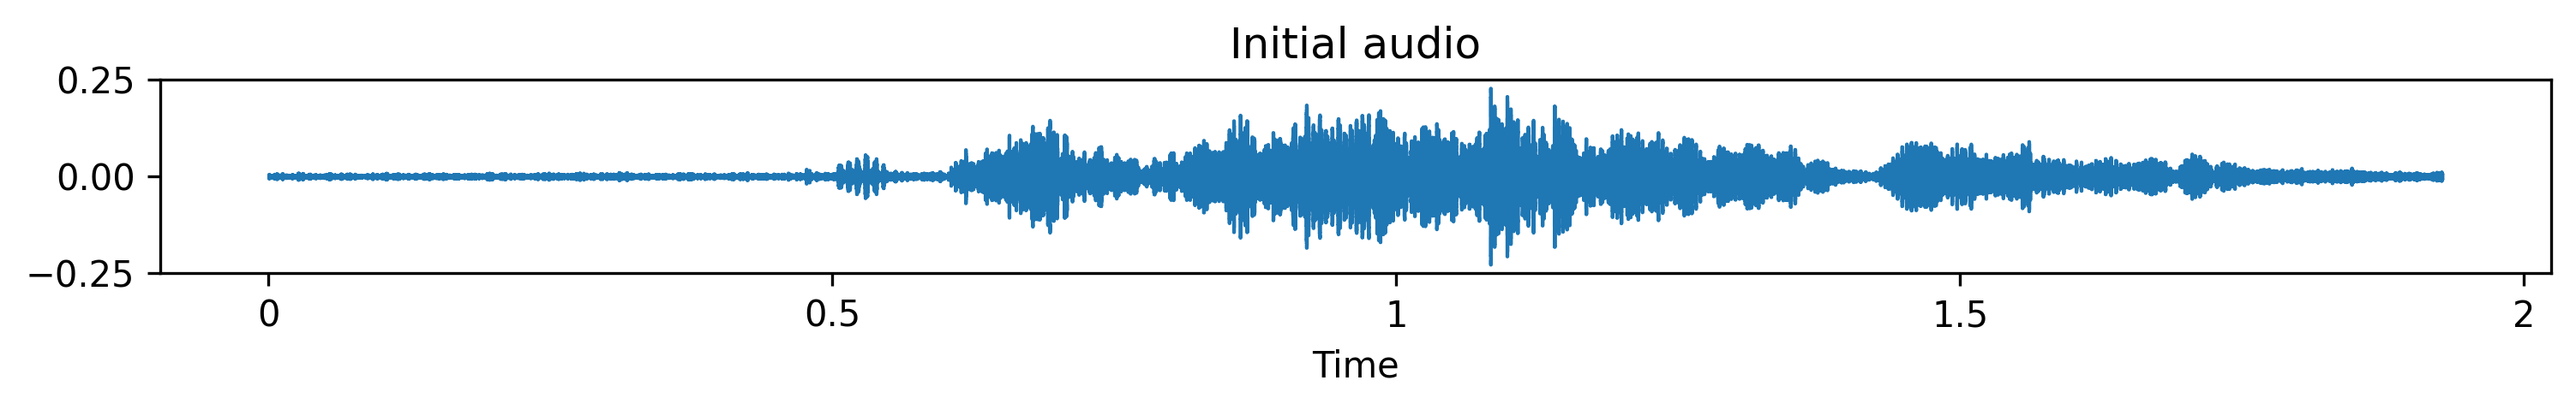

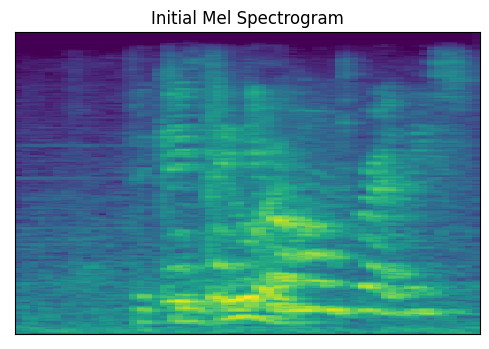

In [17]:
# 1. Load the audio file into an 'AudioSegment' object, and extract the sample rate. 
#    'x' is an array of samples that is only relevant for visualization at this part.

x, sr = librosa.load(path, sr = None)

plt.figure(figsize=(12,1), dpi=300)
librosa.display.waveshow(x, sr)
plt.title('Initial audio')
plt.show()

fig = plt.figure(dpi=100)
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=256, n_fft=2048, hop_length=512), ref=np.max), cmap="viridis")
fig.savefig('test-mel.png', bbox_inches='tight', pad_inches=0, dpi=100)
plt.title('Initial Mel Spectrogram')
plt.show()

display(Audio(x, sr))

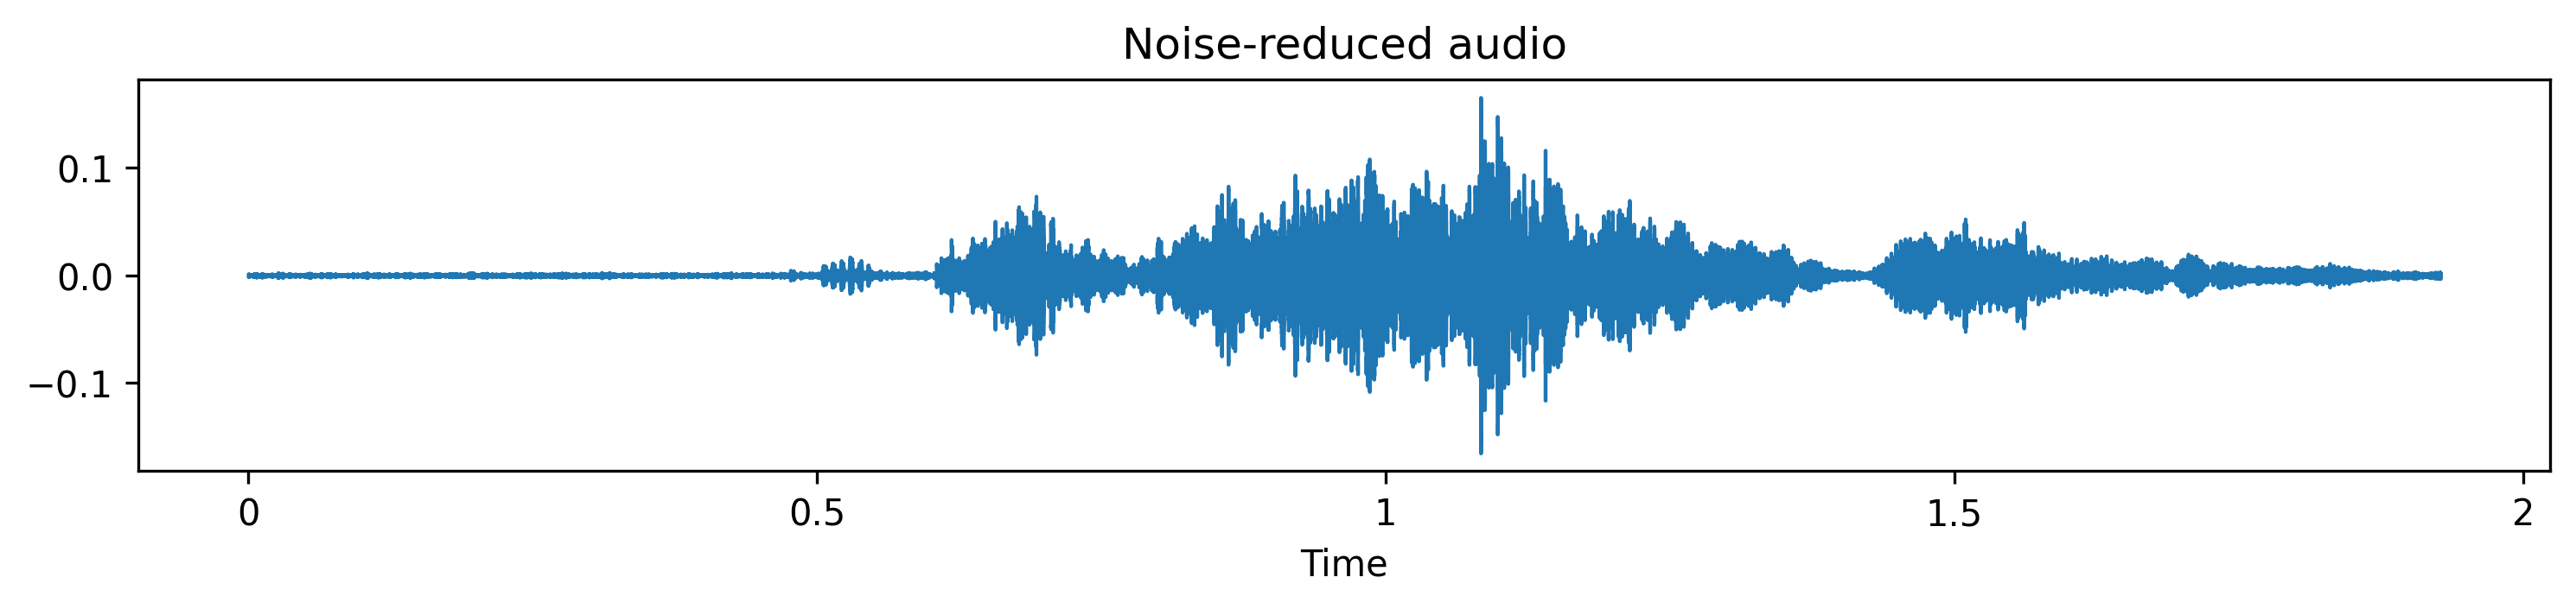

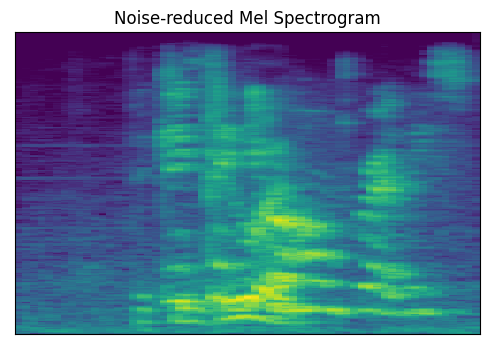

In [18]:
# 2. Noise reduction

nr_x = nr.reduce_noise(y=x, sr=sr, n_fft=2048, hop_length=512, prop_decrease=.75, time_constant_s=1)

plt.figure(figsize=(12,2), dpi=300)
librosa.display.waveshow(nr_x, sr)
plt.title('Noise-reduced audio')
plt.show()

fig = plt.figure(dpi=100)
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=nr_x, sr=sr, n_mels=256, n_fft=2048, hop_length=512), ref=np.max), cmap="viridis")
fig.savefig('test-mel-nr.png', bbox_inches='tight', pad_inches=0, dpi=100)
plt.title('Noise-reduced Mel Spectrogram')
plt.show()

display(Audio(nr_x, sr))

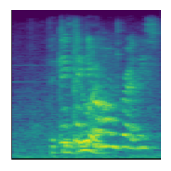

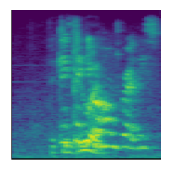

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


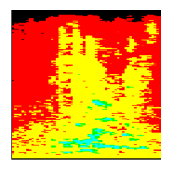

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


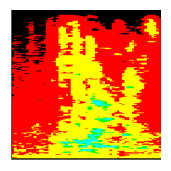

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

def tf_load_image(filename, preprocess=False):
    fig = plt.figure(figsize=(2,2), dpi=100)
    ax = fig.add_subplot()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    img_size = 224
    img = load_img(filename, target_size=(img_size, img_size))
    if preprocess:
        img = img_to_array(img)
        img = preprocess_input(img)
    plt.imshow(img)
    plt.show()

tf_load_image('test-mel.png')
tf_load_image('test-mel-nr.png')
tf_load_image('test-mel.png', preprocess=True)
tf_load_image('test-mel-nr.png', preprocess=True)

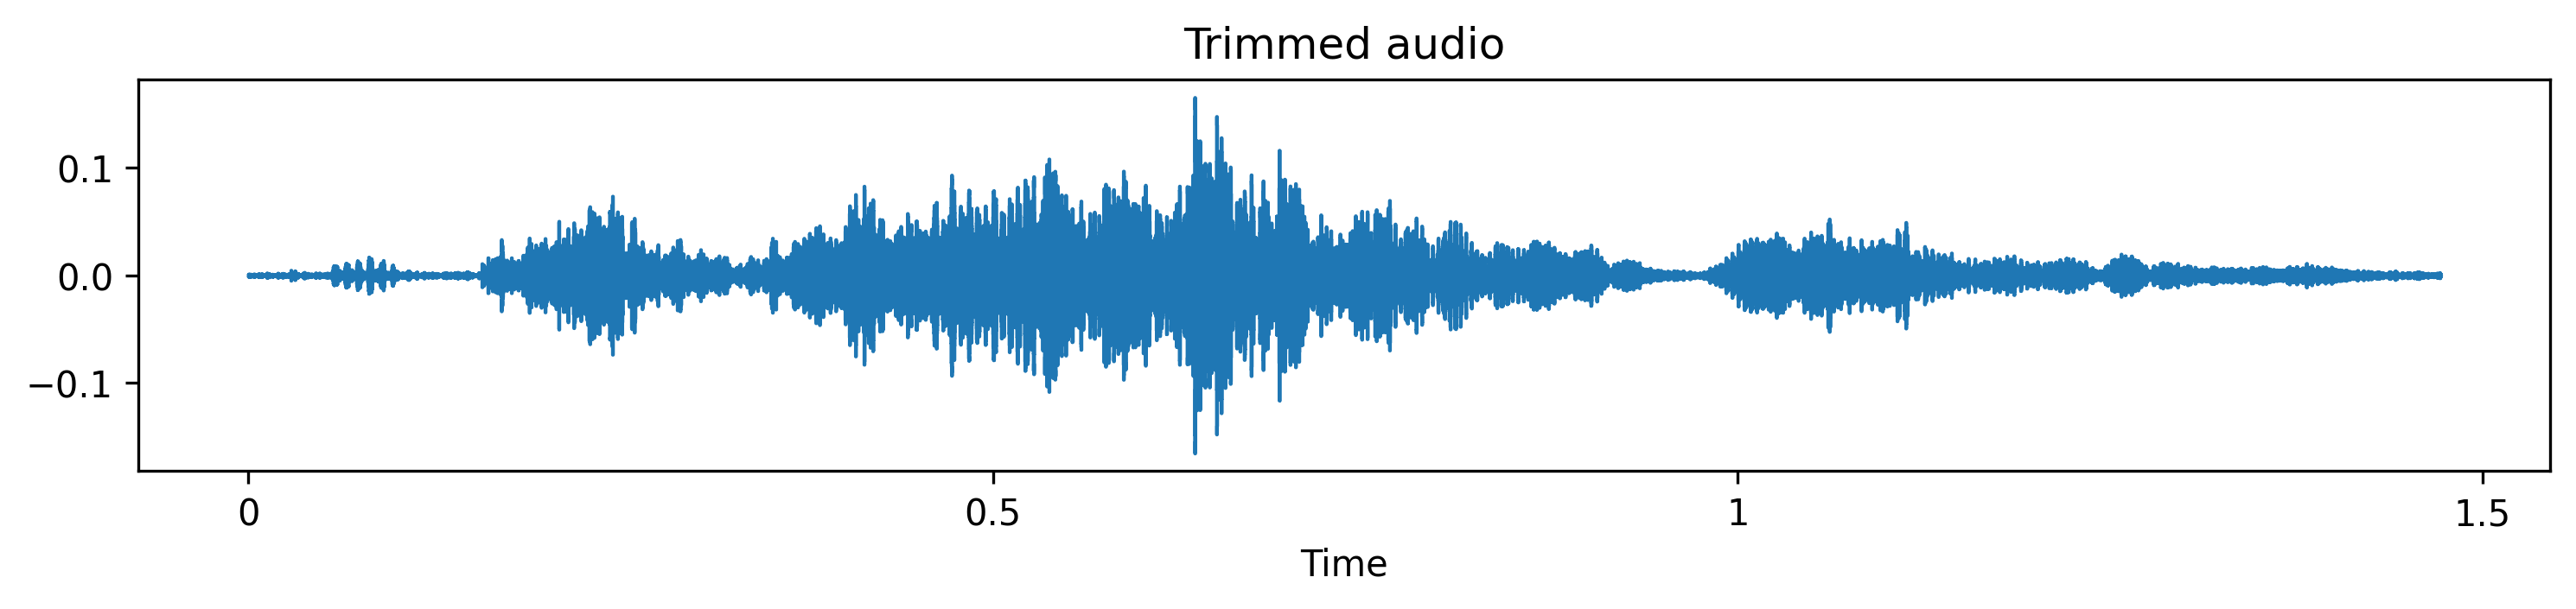

0.3305215419501135


In [26]:
# 3. Trim silence in the beginning and end.
# 30 decibels and lower are considered as silence
xt, _ = librosa.effects.trim(nr_x, top_db=30)

plt.figure(figsize=(12,2))
librosa.display.waveshow(xt, sr)
plt.title('Trimmed audio')
plt.show()

print(librosa.get_duration(nr_x) - librosa.get_duration(xt))

display(Audio(xt, sr))

In [2]:
def preprocess_audio(y, sr):
    y = nr.reduce_noise(y=y, sr=sr, n_fft=2048, hop_length=512, prop_decrease=.75, time_constant_s=1)
    y, _ = librosa.effects.trim(y, top_db=30)
    return y

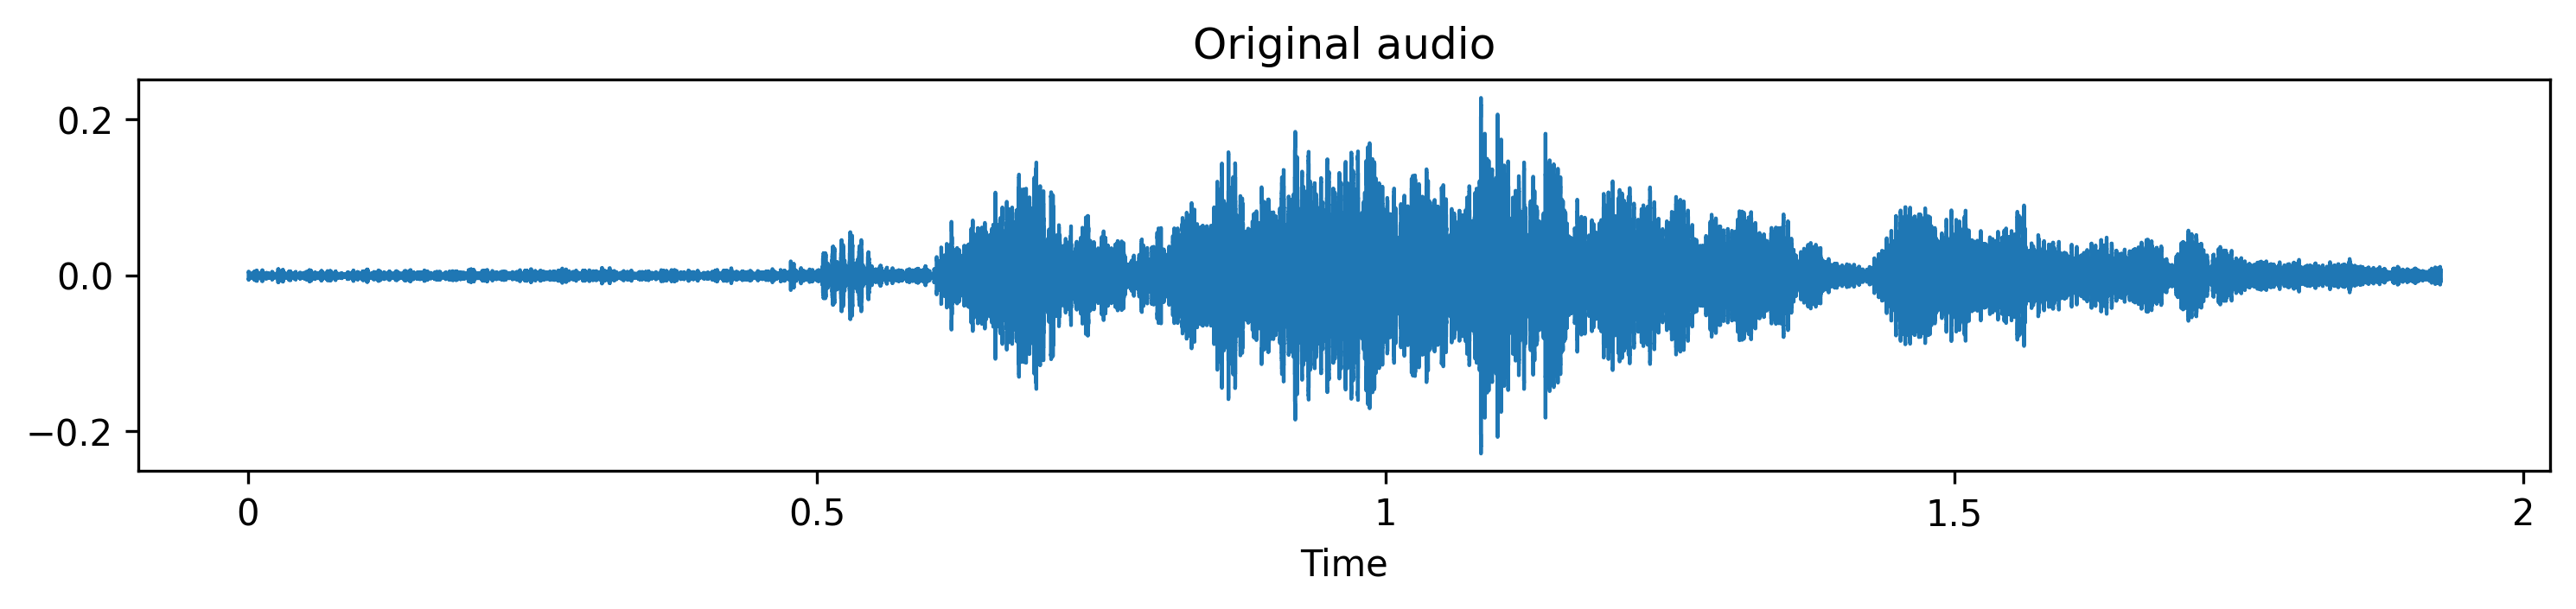

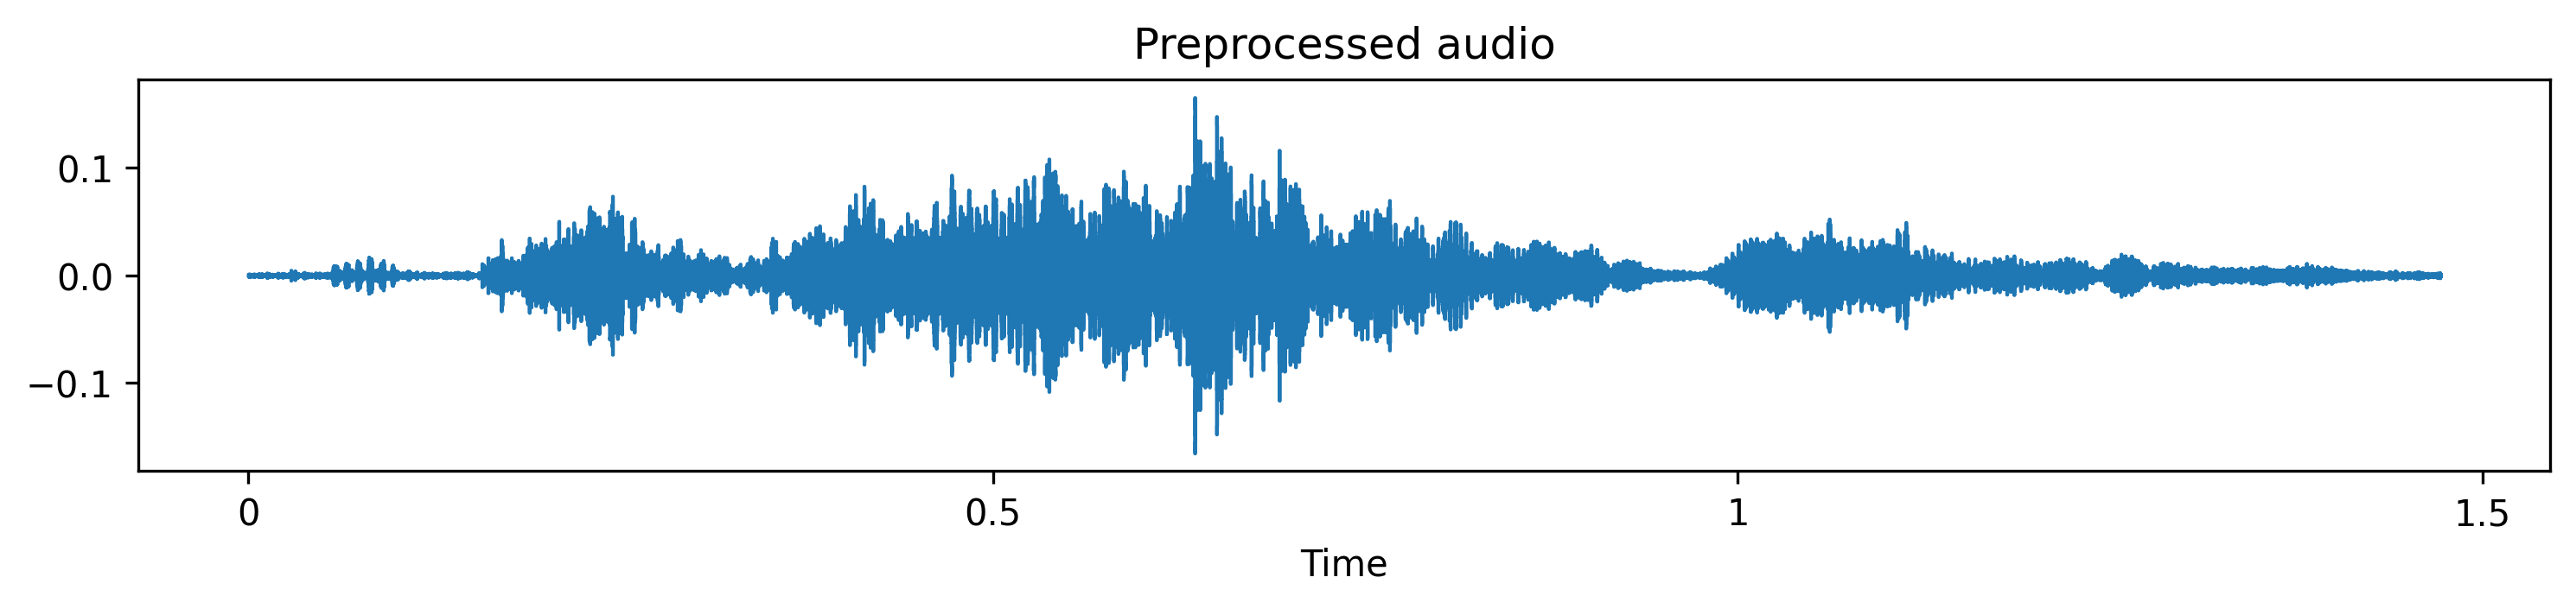

In [32]:
plt.figure(figsize=(12,2))
librosa.display.waveshow(x, sr)
plt.title('Original audio')
plt.show()

display(Audio(x, sr))

plt.figure(figsize=(12,2))
librosa.display.waveshow(preprocess_audio(x, sr), sr)
plt.title('Preprocessed audio')
plt.show()

display(Audio(preprocess_audio(x, sr), sr))

In [3]:
def get_metrics(y_labels, y_pred, folds_size, train_times, prediction_times, draw_corr_matrix=True):
    accs = []
    i = 0
    for f_i in range(5):
      acc = round(metrics.accuracy_score(
          y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]) * 100, 2)
      print(f"Accuracy for fold {f_i}: {acc}%")
      accs.append(acc)
      i += folds_size[f_i]

    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
        ["Training Time", f"{round(np.sum(train_times), 2)}+-{round(np.std(train_times), 2)}"],
        ["Prediction Time", f"{round(np.sum(prediction_times), 2)}+-{round(np.std(prediction_times), 2)}"],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))
    print()
    print(metrics.classification_report(y_labels, y_pred))

    if draw_corr_matrix:
        ticks = ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred, normalize='all')
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()


In [4]:
def categorical_cross_validation(get_new_model, cv=5, draw_corr_matrix=True):
    train_times = []
    prediction_times = []
    folds_size = []

    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        # scaler = MinMaxScaler((-1, 1))
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        # X_train = scaler.fit_transform(X_train)
        # X_test = scaler.transform(X_test)

        folds_size.append(len(y_test))

        start_time = time.time()
        model.fit(X_train, y_train.values.ravel())
        train_times.append(time.time() - start_time)

        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_times.append(time.time() - start_time)

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test.values.ravel())

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, folds_size, train_times, prediction_times, draw_corr_matrix)

In [38]:
def get_new_model():
    return RandomForest(n_estimators=2000, n_jobs=-1, random_state=0, max_features=10)

Number of Audio Files: 5531
Number of Features: 35
Accuracy for fold 0: 59.8%
Accuracy for fold 1: 59.22%
Accuracy for fold 2: 60.76%
Accuracy for fold 3: 59.95%
Accuracy for fold 4: 59.76%

Metric             Value
-----------------  -----------
Accuracy           59.9+-0.5
F1 score macro     60.73
Precision          61.61
Recall             60.44
Matthews corrcoef  0.457
Training Time      49.42+-0.23
Prediction Time    4.42+-0.03

              precision    recall  f1-score   support

           0       0.70      0.60      0.65      1103
           1       0.57      0.50      0.54      1636
           2       0.64      0.67      0.66      1084
           3       0.54      0.65      0.59      1708

    accuracy                           0.60      5531
   macro avg       0.62      0.60      0.61      5531
weighted avg       0.60      0.60      0.60      5531



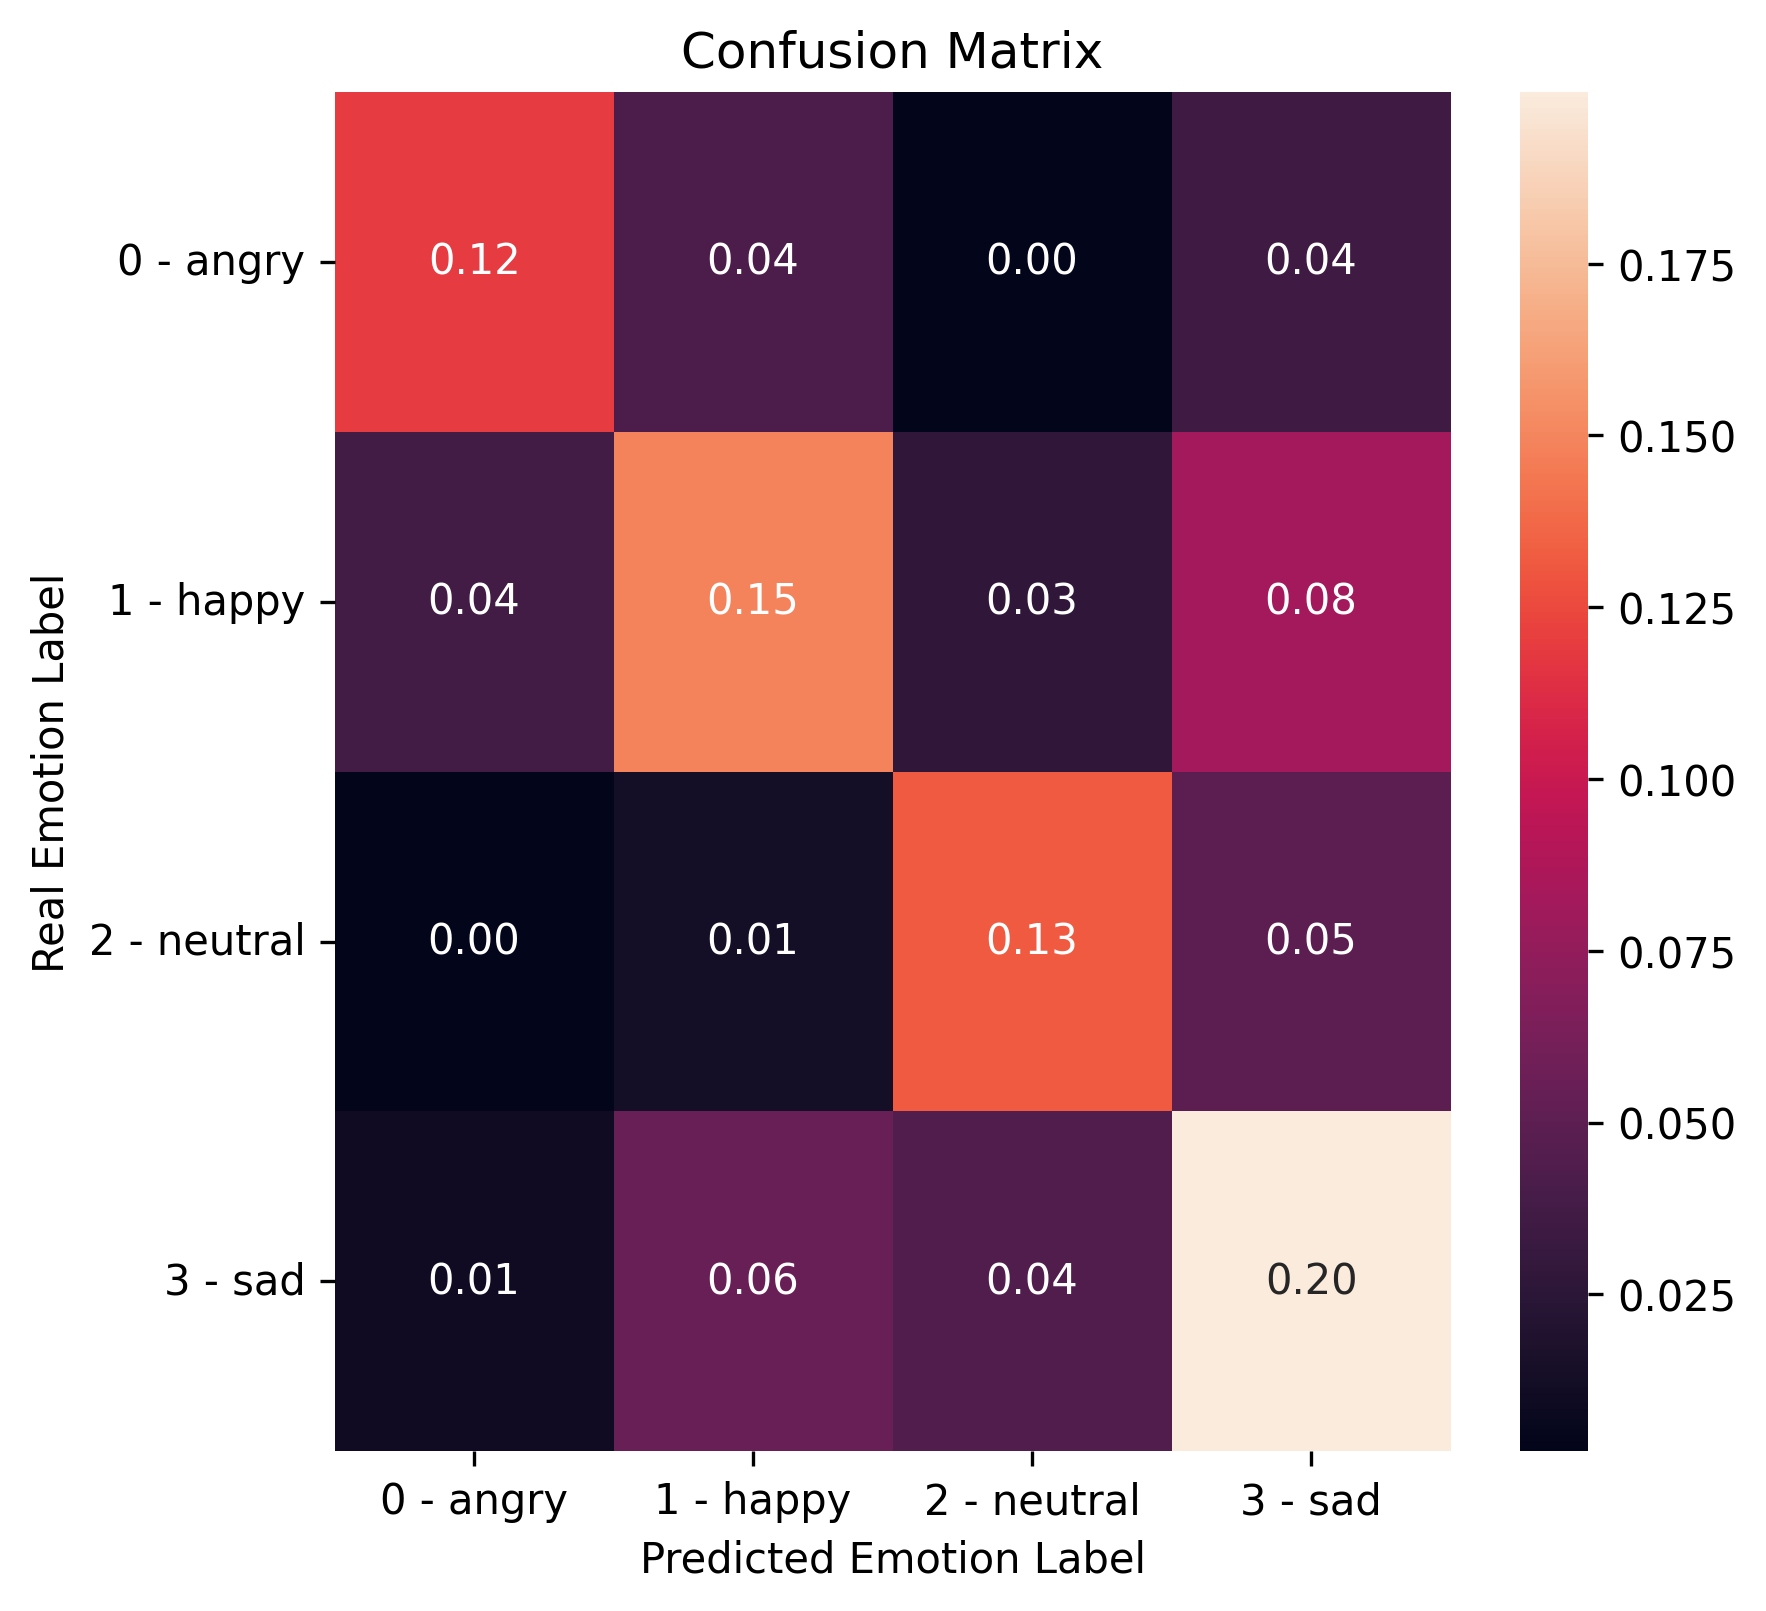

In [39]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
print(f"Number of Features: {len(df.iloc[:,8:].columns)}")
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
categorical_cross_validation(get_new_model)

Number of Audio Files: 5531
Number of Features: 327
Accuracy for fold 0: 63.32%
Accuracy for fold 1: 61.57%
Accuracy for fold 2: 62.39%
Accuracy for fold 3: 61.21%
Accuracy for fold 4: 61.93%

Metric             Value
-----------------  -----------
Accuracy           62.09+-0.73
F1 score macro     62.77
Precision          64.13
Recall             62.27
Matthews corrcoef  0.487
Training Time      48.42+-0.2
Prediction Time    4.45+-0.01

              precision    recall  f1-score   support

           0       0.74      0.59      0.66      1103
           1       0.60      0.53      0.57      1636
           2       0.66      0.68      0.67      1084
           3       0.56      0.69      0.62      1708

    accuracy                           0.62      5531
   macro avg       0.64      0.62      0.63      5531
weighted avg       0.63      0.62      0.62      5531



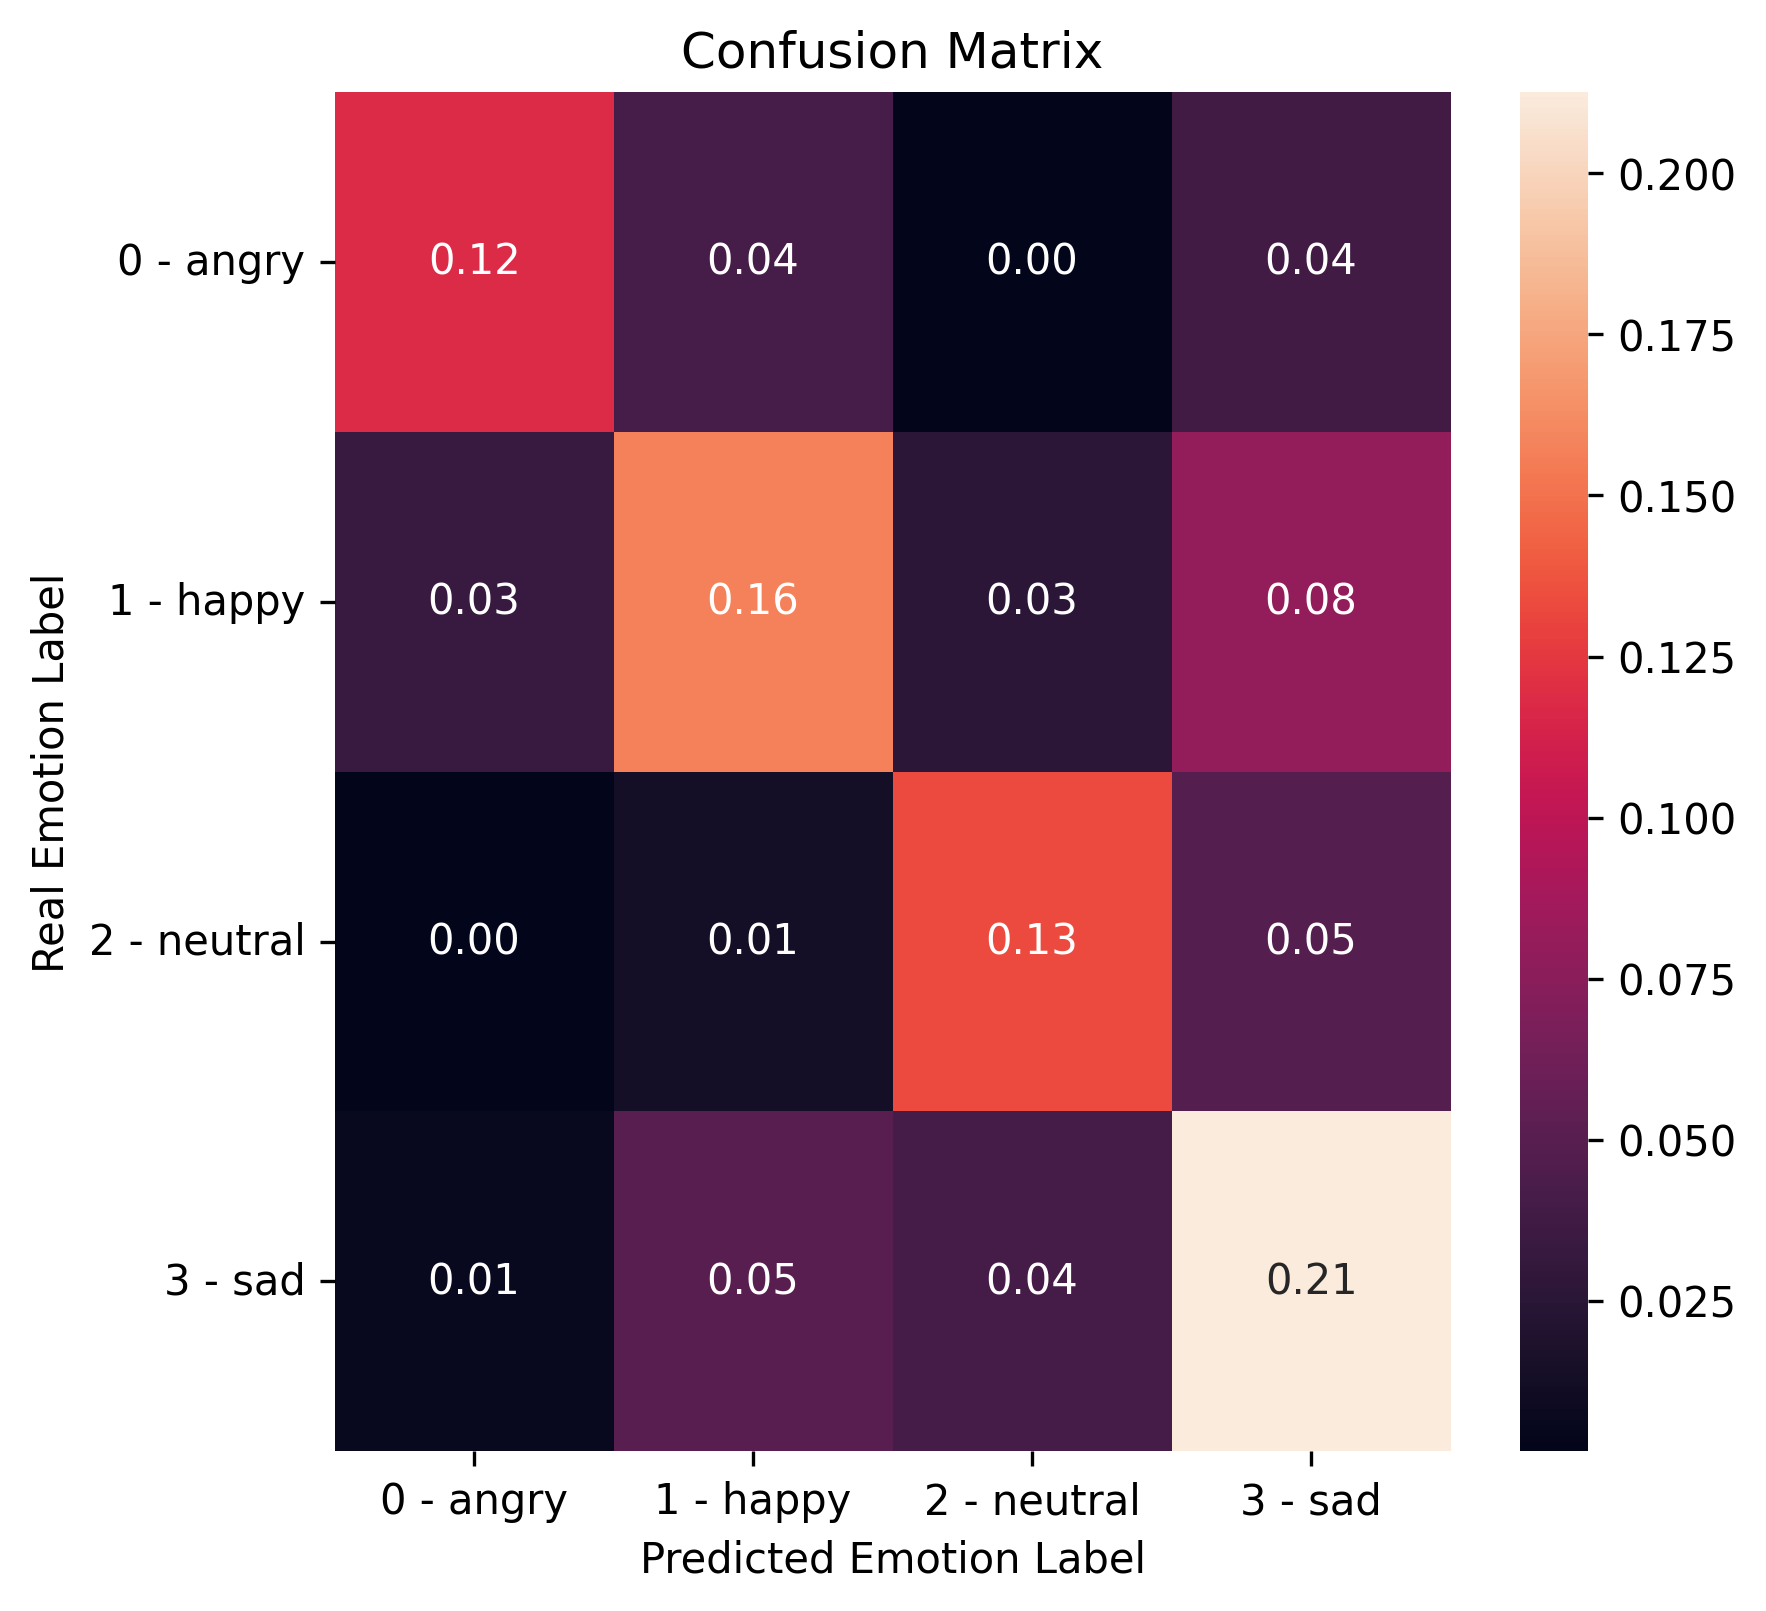

In [41]:
df = pd.read_csv(ALL_EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
print(f"Number of Features: {len(df.iloc[:,8:].columns)}")
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
categorical_cross_validation(get_new_model)

Number of Audio Files: 5531
Number of Features: 35
Accuracy for fold 0: 58.27%
Accuracy for fold 1: 56.33%
Accuracy for fold 2: 55.61%
Accuracy for fold 3: 58.95%
Accuracy for fold 4: 54.43%

Metric             Value
-----------------  -----------
Accuracy           56.72+-1.67
F1 score macro     57.22
Precision          58.31
Recall             56.93
Matthews corrcoef  0.414
Training Time      49.47+-0.35
Prediction Time    4.13+-0.03

              precision    recall  f1-score   support

           0       0.65      0.53      0.58      1103
           1       0.54      0.47      0.50      1636
           2       0.62      0.64      0.63      1084
           3       0.52      0.64      0.58      1708

    accuracy                           0.57      5531
   macro avg       0.58      0.57      0.57      5531
weighted avg       0.57      0.57      0.57      5531



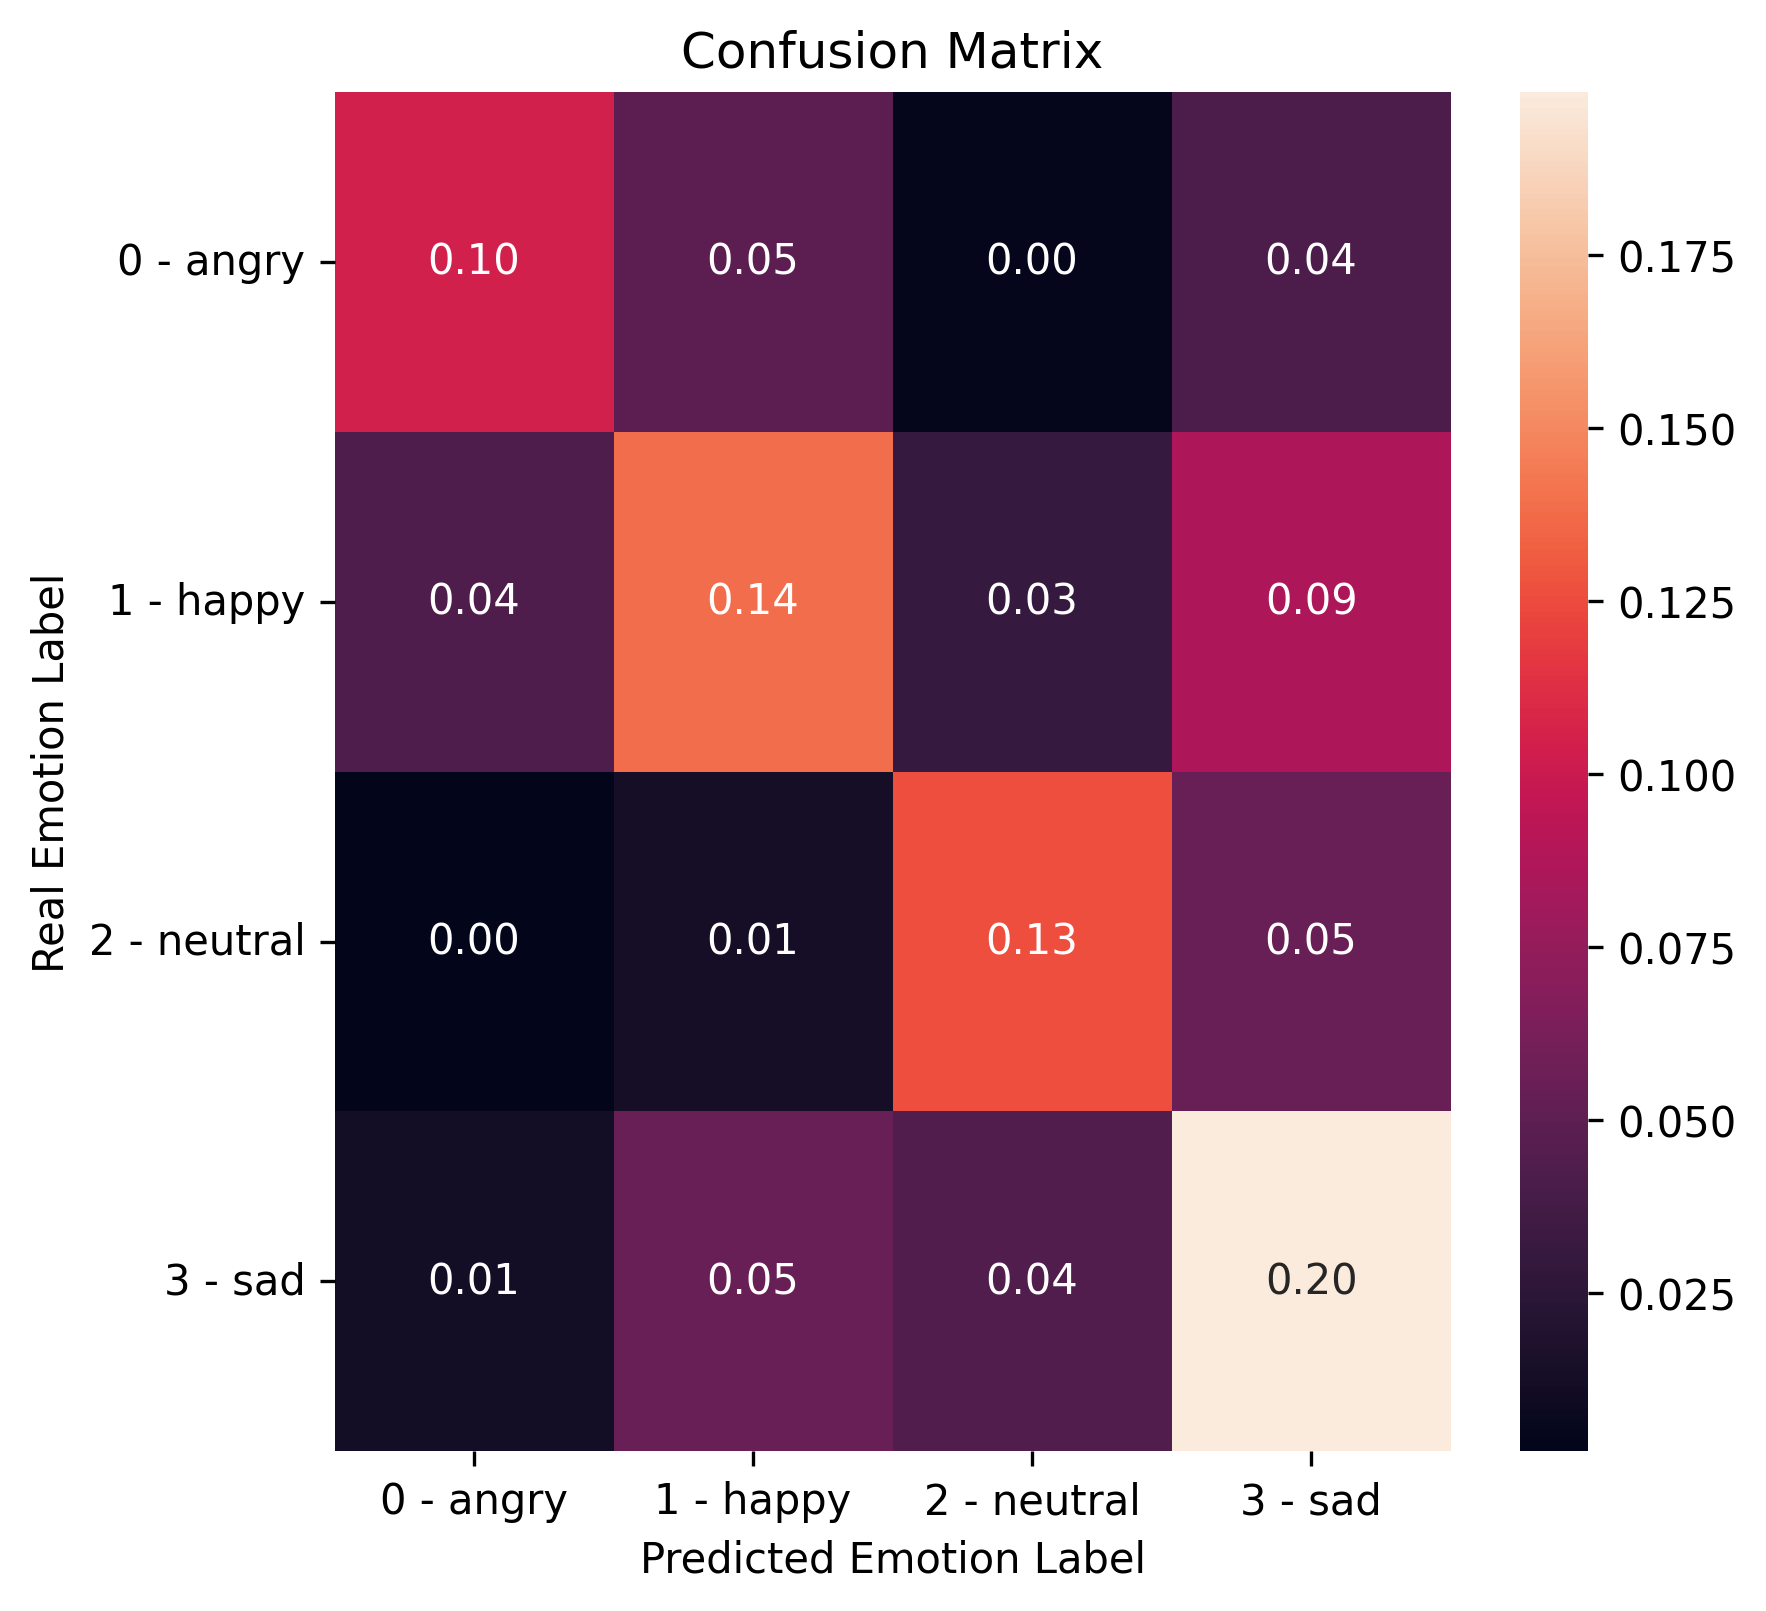

In [40]:
df = pd.read_csv(PREPROCESSED_EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
print(f"Number of Features: {len(df.iloc[:,8:].columns)}")
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
categorical_cross_validation(get_new_model)

Number of Audio Files: 5531
Number of Features: 327
Accuracy for fold 0: 61.88%
Accuracy for fold 1: 60.67%
Accuracy for fold 2: 60.4%
Accuracy for fold 3: 61.03%
Accuracy for fold 4: 60.76%

Metric             Value
-----------------  -----------
Accuracy           60.95+-0.51
F1 score macro     61.66
Precision          62.93
Recall             61.16
Matthews corrcoef  0.471
Training Time      48.32+-0.17
Prediction Time    4.38+-0.02

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1103
           1       0.59      0.51      0.55      1636
           2       0.66      0.66      0.66      1084
           3       0.55      0.68      0.61      1708

    accuracy                           0.61      5531
   macro avg       0.63      0.61      0.62      5531
weighted avg       0.62      0.61      0.61      5531



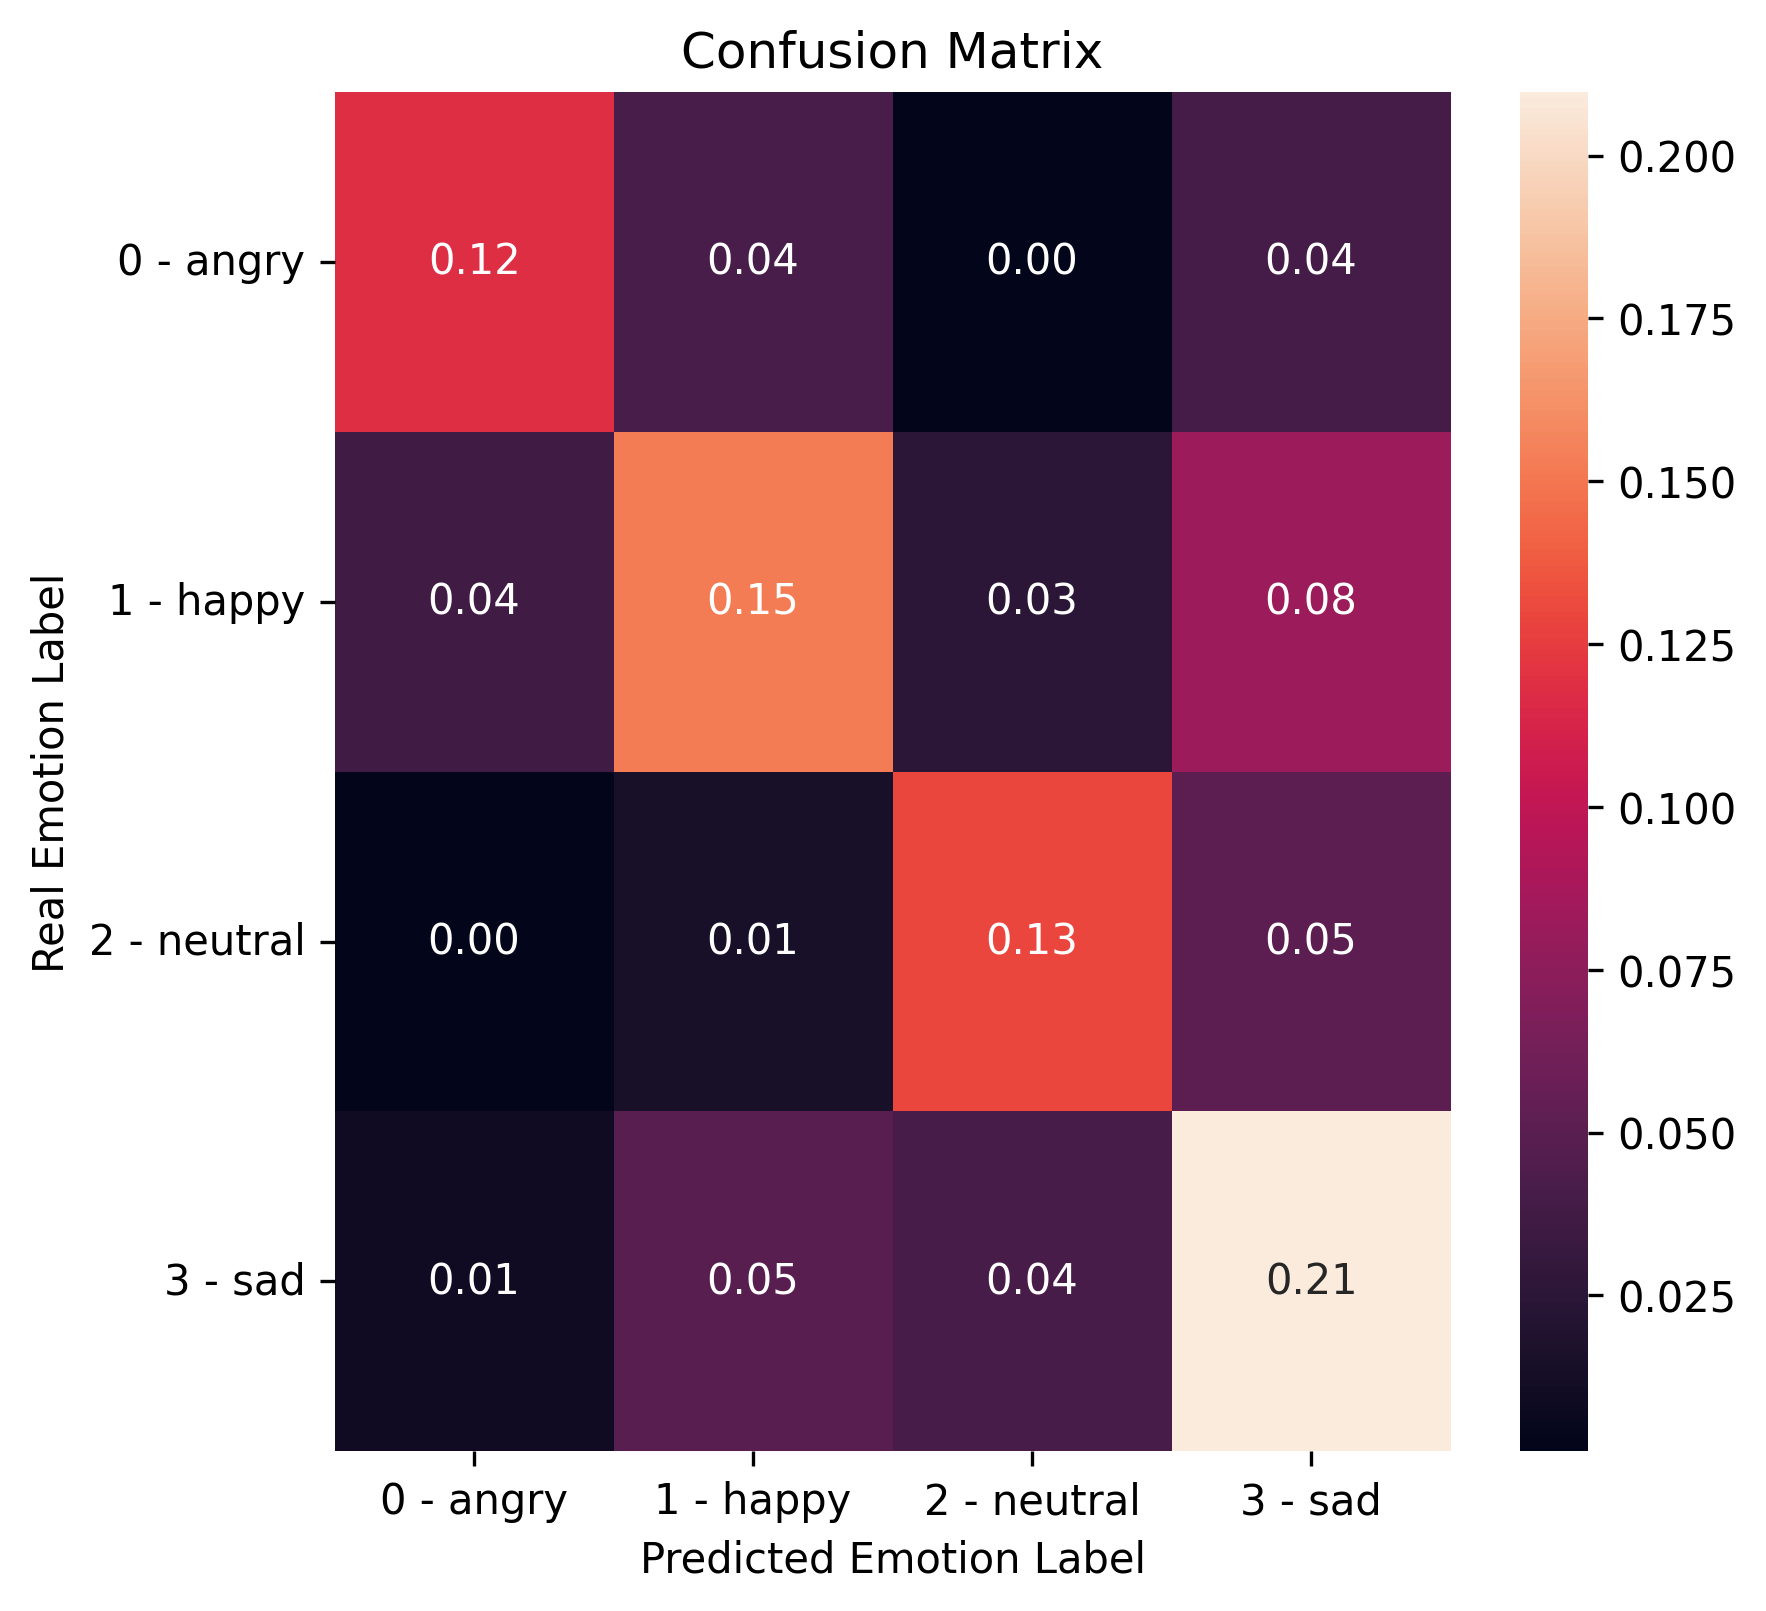

In [42]:
df = pd.read_csv(PREPROCESSED_ALL_EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
print(f"Number of Features: {len(df.iloc[:,8:].columns)}")
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
categorical_cross_validation(get_new_model)